## BUSI

In [6]:
import os
from pathlib import Path

# === CONFIGURATION ===
base_dir = Path("/mnt/HDD1/tuong/TRUST/dataset/original/BUSI")

num_imgs = 0
num_masks = 0

# === WALK THROUGH SUBFOLDERS (benign, malignant, etc.) ===
for class_dir in base_dir.iterdir():
    if class_dir.is_dir():
        for fname in os.listdir(class_dir):
            if fname.endswith(".png"):
                if "_mask" in fname:
                    num_masks += 1
                else:
                    num_imgs += 1

print(f"✅ Total image files (no '_mask'): {num_imgs}")
print(f"✅ Total mask files (with '_mask'): {num_masks}")


✅ Total image files (no '_mask'): 780
✅ Total mask files (with '_mask'): 798


In [141]:
import os
import random
from PIL import Image, ImageChops
import shutil

random.seed(42)  # For reproducibility
import re

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def create_dirs(base_dir):
    os.makedirs(os.path.join(base_dir, 'imgs'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'masks'), exist_ok=True)

def resize_and_save(src_path, dst_path, size=(256, 256), is_mask=False):
    img = Image.open(src_path)
    resample_method = Image.NEAREST if is_mask else Image.BILINEAR
    img = img.resize(size, resample=resample_method)
    img.save(dst_path)

def merge_all_masks(class_dir, filename):
    """
    Merge all masks corresponding to an image (logical OR).
    
    Args:
        class_dir (str): Path to the class folder.
        filename (str): Original image filename (e.g., 'benign (4).png').
    
    Returns:
        PIL.Image: Merged mask image (binary).
    """
    import re
    def natural_sort_key(s):
        return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

    base_name = filename.replace('.png', '')
    mask_files = [f for f in os.listdir(class_dir) 
                  if f.startswith(base_name + '_mask') and f.endswith('.png')]
    
    if not mask_files:
        print(f"⚠️ WARNING: No mask found for image {filename}.")
        return None

    # Sort the mask files naturally (e.g., _mask.png, _mask_1.png, _mask_2.png, ...)
    mask_files = sorted(mask_files, key=natural_sort_key)

    merged_mask = None
    for mask_file in mask_files:
        mask = Image.open(os.path.join(class_dir, mask_file)).convert('L')
        mask = mask.point(lambda p: p > 0 and 255)  # Ensure binary (0 or 255)
        if merged_mask is None:
            merged_mask = mask
        else:
            # Pixel-wise OR operation
            merged_mask = ImageChops.lighter(merged_mask, mask)

    return merged_mask

def process_class_to_full(class_dir, class_name, full_dir, full_list):
    all_files = [f for f in os.listdir(class_dir) if f.endswith('.png') and '_mask' not in f]
    all_files = sorted(all_files, key=natural_sort_key)

    for idx, filename in enumerate(all_files):
        img_src = os.path.join(class_dir, filename)
        merged_mask = merge_all_masks(class_dir, filename)
        
        if merged_mask is None:
            print(f"⏩ Skipping {filename} due to missing mask.")
            continue

        new_name = filename.replace(" ", "_") # f"{class_name}_{idx:04d}.png"
        # Save resized image
        resize_and_save(img_src, os.path.join(full_dir, 'imgs', new_name), is_mask=False)
        # Resize and save merged mask
        merged_mask = merged_mask.resize((256, 256), resample=Image.NEAREST)
        merged_mask.save(os.path.join(full_dir, 'masks', new_name))

        full_list.append(new_name)

def split_from_full(full_dir, output_dir, full_list, split_ratio=0.8):
    train_dir = os.path.join(output_dir, 'train')
    valid_dir = os.path.join(output_dir, 'valid')
    create_dirs(train_dir)
    create_dirs(valid_dir)

    random.shuffle(full_list)
    split_idx = int(len(full_list) * split_ratio)
    train_files = full_list[:split_idx]
    valid_files = full_list[split_idx:]

    train_list, valid_list = [], []

    for filename in train_files:
        shutil.copy(os.path.join(full_dir, 'imgs', filename), os.path.join(train_dir, 'imgs', filename))
        shutil.copy(os.path.join(full_dir, 'masks', filename), os.path.join(train_dir, 'masks', filename))
        train_list.append(f"Breast-BUSI/train/imgs/{filename}")

    for filename in valid_files:
        shutil.copy(os.path.join(full_dir, 'imgs', filename), os.path.join(valid_dir, 'imgs', filename))
        shutil.copy(os.path.join(full_dir, 'masks', filename), os.path.join(valid_dir, 'masks', filename))
        valid_list.append(f"Breast-BUSI/valid/imgs/{filename}")

    return train_list, valid_list

def split_and_process_dataset(original_dir, output_dir, split_ratio=0.7):
    full_dir = os.path.join(output_dir, 'full')
    create_dirs(full_dir)
    class_names = ['benign', 'malignant']
    full_list = []

    # Step 1: Process to full folder first
    for class_name in class_names:
        class_dir = os.path.join(original_dir, class_name)
        process_class_to_full(class_dir, class_name, full_dir, full_list)
        print(f"✅ Processed class to full: {class_name}")

    # Step 2: Split from full folder
    train_list, valid_list = split_from_full(full_dir, output_dir, full_list, split_ratio=split_ratio)

    # Write txt files
    with open(os.path.join(output_dir, 'train.txt'), 'w') as f:
        for item in train_list:
            f.write(item + '\n')

    with open(os.path.join(output_dir, 'valid.txt'), 'w') as f:
        for item in valid_list:
            f.write(item + '\n')

    with open(os.path.join(output_dir, 'full.txt'), 'w') as f:
        for item in full_list:
            f.write(f"Breast-BUSI/full/imgs/{item}\n")

    print("✅ Saved train.txt, valid.txt, full.txt and split dataset successfully!")

# ==========================
# Example usage:
original_dataset = '/mnt/HDD1/tuong/TRUST/dataset/original/BUSI'
output_dataset = '/mnt/HDD1/tuong/TRUST/dataset/Breast-BUSI'

split_and_process_dataset(original_dataset, output_dataset)


✅ Processed class to full: benign
✅ Processed class to full: malignant
✅ Saved train.txt, valid.txt, full.txt and split dataset successfully!


In [133]:
import os

train_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/Breast-BUSI/train/imgs')
valid_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/Breast-BUSI/valid/imgs')

total_len = len(train_len) + len(valid_len)

print(f"Total images in train: {len(train_len)}")
print(f"Total images in valid: {len(valid_len)}")
print(f"Total images in dataset: {total_len}")

Total images in train: 452
Total images in valid: 195
Total images in dataset: 647


## UCLM

In [6]:
import os 

print(len(os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/UCLM/images')))
print(len(os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/UCLM/masks')))

683
683


In [ ]:
import os
import random
from PIL import Image
import numpy as np
import shutil

random.seed(42)

def create_dirs(base_dir):
    os.makedirs(os.path.join(base_dir, 'imgs'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'masks'), exist_ok=True)

def convert_mask_to_binary_white(mask_path):
    mask = np.array(Image.open(mask_path))
    binary_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    if mask.ndim == 3:
        binary_mask[np.all(mask == [255, 0, 0], axis=-1)] = 255  # Malignant
        binary_mask[np.all(mask == [0, 255, 0], axis=-1)] = 255  # Benign
    return Image.fromarray(binary_mask)

def resize_and_save(src_path, dst_path, size=(256, 256), is_mask=False):
    if is_mask:
        mask = convert_mask_to_binary_white(src_path)
        mask = mask.resize(size, resample=Image.NEAREST)
        mask.save(dst_path)
    else:
        img = Image.open(src_path)
        img = img.resize(size, resample=Image.BILINEAR)
        img.save(dst_path)

def classify_mask(mask_path):
    if not os.path.exists(mask_path):
        return None  # Skip normal

    mask = np.array(Image.open(mask_path))
    if mask.ndim == 3:
        if np.any(np.all(mask == [255, 0, 0], axis=-1)):
            return 'malignant'
        elif np.any(np.all(mask == [0, 255, 0], axis=-1)):
            return 'benign'
    return None  # Skip if no target class color

def process_dataset(image_dir, mask_dir, output_dir, split_ratio=0.7):
    images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

    # Filter and assign class
    filtered_images = []
    class_map = {}

    for filename in images:
        mask_path = os.path.join(mask_dir, filename)
        class_name = classify_mask(mask_path)
        if class_name is not None:
            filtered_images.append(filename)
            class_map[filename] = class_name

    full_dir = os.path.join(output_dir, 'full')
    create_dirs(full_dir)
    full_list = []

    class_counters = {'benign': 0, 'malignant': 0}

    # === Step 1: Generate FULL first (resize + rename) ===
    for filename in filtered_images:
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)
        class_name = class_map[filename]
        index = class_counters[class_name]
        new_name = f"{class_name}_{index:04d}.png"
        class_counters[class_name] += 1

        resize_and_save(img_path, os.path.join(full_dir, 'imgs', new_name), is_mask=False)
        resize_and_save(mask_path, os.path.join(full_dir, 'masks', new_name), is_mask=True)
        full_list.append(new_name)

    # Write full.txt
    with open(os.path.join(output_dir, 'full.txt'), 'w') as f:
        for item in full_list:
            f.write(f"Breast-UCLM/full/imgs/{item}\n")

    # === Step 2: Split from FULL ===
    random.shuffle(full_list)
    split_idx = int(len(full_list) * split_ratio)
    train_files = full_list[:split_idx]
    valid_files = full_list[split_idx:]

    for subset_name, subset_files in [('train', train_files), ('valid', valid_files)]:
        subset_dir = os.path.join(output_dir, subset_name)
        create_dirs(subset_dir)
        with open(os.path.join(output_dir, f"{subset_name}.txt"), 'w') as f:
            for filename in subset_files:
                shutil.copy(os.path.join(full_dir, 'imgs', filename), os.path.join(subset_dir, 'imgs', filename))
                shutil.copy(os.path.join(full_dir, 'masks', filename), os.path.join(subset_dir, 'masks', filename))
                f.write(f"Breast-UCLM/{subset_name}/imgs/{filename}\n")

    print("✅ Process completed! No duplicated names between train/valid.")

# === Example usage ===
image_dir = '/mnt/HDD1/tuong/TRUST/dataset/original/UCLM/images'
mask_dir = '/mnt/HDD1/tuong/TRUST/dataset/original/UCLM/masks'
output_dir = '/mnt/HDD1/tuong/TRUST/dataset/Breast-UCLM'

process_dataset(image_dir, mask_dir, output_dir)

✅ Process completed! No duplicated names between train/valid.


In [127]:
import os

images_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/UCLM/images')
masks_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/UCLM/masks')


print(f"Total images: {len(images_len)}")
print(f"Total masks: {len(masks_len)}")

Total images: 683
Total masks: 683


In [136]:
import os

train_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/Breast-UCLM/train/imgs')
valid_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/Breast-UCLM/valid/imgs')

total_len = len(train_len) + len(valid_len)

print(f"Total images in train: {len(train_len)}")
print(f"Total images in valid: {len(valid_len)}")
print(f"Total images in dataset: {total_len}")

Total images in train: 184
Total images in valid: 80
Total images in dataset: 264


## BUSBRA

In [5]:
import os 

print(len(os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/BUSBRA/images')))
print(len(os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/BUSBRA/masks')))

1875
1875


In [ ]:
import os
import random
from PIL import Image
import shutil

random.seed(42)

def create_dirs(base_dir):
    os.makedirs(os.path.join(base_dir, 'imgs'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, 'masks'), exist_ok=True)

def resize_and_save(src_path, dst_path, size=(256, 256), is_mask=False):
    img = Image.open(src_path)
    resample_method = Image.NEAREST if is_mask else Image.BILINEAR
    img = img.resize(size, resample=resample_method)
    img.save(dst_path)

def get_class_from_filename(filename):
    if filename.startswith('benign'):
        return 'benign'
    elif filename.startswith('malignant'):
        return 'malignant'
    else:
        return 'unknown'

def process_busbra_dataset(image_dir, mask_dir, output_dir, split_ratio=0.7):
    images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    full_dir = os.path.join(output_dir, 'full')
    create_dirs(full_dir)
    full_list = []
    class_counters = {'benign': 0, 'malignant': 0}

    for filename in images:
        img_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # Same name for mask

        class_name = get_class_from_filename(filename)
        if class_name not in class_counters:
            print(f"⚠️ WARNING: Unknown class for {filename}. Skipping...")
            continue

        if not os.path.exists(mask_path):
            print(f"⚠️ WARNING: No mask found for {filename}. Skipping...")
            continue

        index = class_counters[class_name]
        new_name = filename.replace(" ", "_") # f"{class_name}_{index:04d}.png"
        class_counters[class_name] += 1

        resize_and_save(img_path, os.path.join(full_dir, 'imgs', new_name), is_mask=False)
        resize_and_save(mask_path, os.path.join(full_dir, 'masks', new_name), is_mask=True)
        full_list.append(new_name)

    # Write full.txt
    with open(os.path.join(output_dir, 'full.txt'), 'w') as f:
        for item in full_list:
            f.write(f"BUSBRA/full/imgs/{item}\n")

    # === Step 2: Split ===
    random.shuffle(full_list)
    split_idx = int(len(full_list) * split_ratio)
    train_files = full_list[:split_idx]
    valid_files = full_list[split_idx:]

    for subset_name, subset_files in [('train', train_files), ('valid', valid_files)]:
        subset_dir = os.path.join(output_dir, subset_name)
        create_dirs(subset_dir)
        with open(os.path.join(output_dir, f"{subset_name}.txt"), 'w') as f:
            for filename in subset_files:
                shutil.copy(os.path.join(full_dir, 'imgs', filename), os.path.join(subset_dir, 'imgs', filename))
                shutil.copy(os.path.join(full_dir, 'masks', filename), os.path.join(subset_dir, 'masks', filename))
                f.write(f"BUSBRA/{subset_name}/imgs/{filename}\n")

    print("✅ Process completed! Train/Valid/Full split done.")

# === Example usage ===
image_dir = '/mnt/HDD1/tuong/TRUST/dataset/original/BUSBRA/images'
mask_dir = '/mnt/HDD1/tuong/TRUST/dataset/original/BUSBRA/masks'
output_dir = '/mnt/HDD1/tuong/TRUST/dataset/BUSBRA'

process_busbra_dataset(image_dir, mask_dir, output_dir)


✅ Process completed! Train/Valid/Full split done.


In [139]:
import os

img_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/BUSBRA/images')
mask_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/BUSBRA/masks')

print(f"Total images in images: {len(img_len)}")
print(f"Total images in masks: {len(mask_len)}")

Total images in images: 1875
Total images in masks: 1875


In [140]:
import os

train_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/BUSBRA/train/imgs')
valid_len = os.listdir('/mnt/HDD1/tuong/TRUST/dataset/BUSBRA/valid/imgs')

total_len = len(train_len) + len(valid_len)

print(f"Total images in train: {len(train_len)}")
print(f"Total images in valid: {len(valid_len)}")
print(f"Total images in dataset: {total_len}")

Total images in train: 1312
Total images in valid: 563
Total images in dataset: 1875


## UDIAT

In [2]:
import os 

print(len(os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/UDIAT/full/imgs')))
print(len(os.listdir('/mnt/HDD1/tuong/TRUST/dataset/original/UDIAT/full/masks')))

163
163


In [10]:
import os
import random
import shutil
from pathlib import Path
from PIL import Image

# === CONFIGURATION ===
base_dir = Path("/mnt/HDD1/tuong/TRUST/dataset/original/UDIAT")
input_img_dir = base_dir / "full" / "imgs"
input_mask_dir = base_dir / "full" / "masks"

outdir = Path("/mnt/HDD1/tuong/TRUST/dataset/Breast-UDIAT")
train_dir = outdir / "train"
valid_dir = outdir / "valid"
full_dir = outdir / "full"

train_txt = outdir / "train.txt"
valid_txt = outdir / "valid.txt"
full_txt = outdir / "full.txt"

train_ratio = 0.7
resize_size = (256, 256)

random.seed(42)  # For reproducibility

# === CREATE OUTPUT FOLDERS ===
for folder in [train_dir, valid_dir, full_dir]:
    (folder / "imgs").mkdir(parents=True, exist_ok=True)
    (folder / "masks").mkdir(parents=True, exist_ok=True)

# === LIST ALL IMAGES ===
all_imgs = sorted([f for f in os.listdir(input_img_dir) if f.endswith(".png")])
random.shuffle(all_imgs)
split_idx = int(len(all_imgs) * train_ratio)
train_files = sorted(all_imgs[:split_idx])
valid_files = sorted(all_imgs[split_idx:])
full_files = sorted(all_imgs)

# === RESIZE AND SAVE FUNCTION ===
def resize_and_save(src_path, dst_path, size=(256, 256), is_mask=False):
    img = Image.open(src_path)
    resample_method = Image.NEAREST if is_mask else Image.BILINEAR
    img = img.resize(size, resample=resample_method)
    img.save(dst_path)

# === COPY TO FULL FOLDER ===
with open(full_txt, "w") as f_full:
    for fname in full_files:
        resize_and_save(input_img_dir / fname, full_dir / "imgs" / fname, size=resize_size, is_mask=False)
        resize_and_save(input_mask_dir / fname, full_dir / "masks" / fname, size=resize_size, is_mask=True)
        f_full.write(f"Breast-UDIAT/full/imgs/{fname}\n")

# === COPY TO TRAIN FOLDER ===
with open(train_txt, "w") as f_train:
    for fname in train_files:
        resize_and_save(input_img_dir / fname, train_dir / "imgs" / fname, size=resize_size, is_mask=False)
        resize_and_save(input_mask_dir / fname, train_dir / "masks" / fname, size=resize_size, is_mask=True)
        f_train.write(f"Breast-UDIAT/train/imgs/{fname}\n")

# === COPY TO VALID FOLDER ===
with open(valid_txt, "w") as f_valid:
    for fname in valid_files:
        resize_and_save(input_img_dir / fname, valid_dir / "imgs" / fname, size=resize_size, is_mask=False)
        resize_and_save(input_mask_dir / fname, valid_dir / "masks" / fname, size=resize_size, is_mask=True)
        f_valid.write(f"Breast-UDIAT/valid/imgs/{fname}\n")

print(f"✅ Done! Train: {len(train_files)}, Valid: {len(valid_files)}, Full: {len(full_files)} (sorted, filenames kept unchanged)")


✅ Done! Train: 114, Valid: 49, Full: 163 (sorted, filenames kept unchanged)


## OASBUD

In [2]:
import glob

imgs_len = len(glob.glob('/mnt/HDD1/tuong/TRUST/dataset/original/OASBUD/imgs/*/*.bmp'))
masks_len = len(glob.glob('/mnt/HDD1/tuong/TRUST/dataset/original/OASBUD/masks/*/*.bmp'))
print(f"Total images in imgs: {imgs_len}")
print(f"Total images in masks: {masks_len}")

Total images in imgs: 200
Total images in masks: 200


In [7]:
import os
import random
from pathlib import Path
from PIL import Image

# === CONFIGURATION ===
base_dir = Path("/mnt/HDD1/tuong/TRUST/dataset/original/OASBUD")
input_img_dir = base_dir / "imgs"
input_mask_dir = base_dir / "masks"

outdir = Path("/mnt/HDD1/tuong/TRUST/dataset/Breast-OASBUD")
train_dir = outdir / "train"
valid_dir = outdir / "valid"
full_dir = outdir / "full"

train_txt = outdir / "train.txt"
valid_txt = outdir / "valid.txt"
full_txt = outdir / "full.txt"

train_ratio = 0.7
resize_size = (256, 256)

random.seed(42)  # Reproducibility

# === CREATE OUTPUT FOLDERS ===
for folder in [train_dir, valid_dir, full_dir]:
    (folder / "imgs").mkdir(parents=True, exist_ok=True)
    (folder / "masks").mkdir(parents=True, exist_ok=True)

# === GATHER ALL FILES FROM SUBFOLDERS (Benign, Malignant, etc.) ===
all_imgs = []
for class_dir in input_img_dir.iterdir():
    if class_dir.is_dir():
        for fname in sorted(os.listdir(class_dir)):
            if fname.endswith(".bmp"):
                all_imgs.append((class_dir.name, fname))  # (class, filename)

random.shuffle(all_imgs)
split_idx = int(len(all_imgs) * train_ratio)
train_files = sorted(all_imgs[:split_idx], key=lambda x: x[1])
valid_files = sorted(all_imgs[split_idx:], key=lambda x: x[1])
full_files = sorted(all_imgs, key=lambda x: x[1])

# === CONVERT + RESIZE + SAVE FUNCTION ===
def convert_resize_save(src_path, dst_path, size=(256, 256), is_mask=False):
    img = Image.open(src_path)
    if not is_mask:
        img = img.convert('RGB')
    resample_method = Image.NEAREST if is_mask else Image.BILINEAR
    img = img.resize(size, resample=resample_method)
    img.save(dst_path, format='PNG')

# === PROCESS FULL ===
with open(full_txt, "w") as f_full:
    for cls, fname in full_files:
        out_fname = fname.replace('.bmp', '.png')
        src_img_path = input_img_dir / cls / fname
        dst_img_path = full_dir / "imgs" / out_fname
        convert_resize_save(src_img_path, dst_img_path, size=resize_size, is_mask=False)

        # Process mask
        src_mask_path = input_mask_dir / cls / fname
        dst_mask_path = full_dir / "masks" / out_fname
        convert_resize_save(src_mask_path, dst_mask_path, size=resize_size, is_mask=True)

        f_full.write(f"Breast-OASBUD/full/imgs/{out_fname}\n")

# === PROCESS TRAIN ===
with open(train_txt, "w") as f_train:
    for cls, fname in train_files:
        out_fname = fname.replace('.bmp', '.png')
        src_img_path = input_img_dir / cls / fname
        dst_img_path = train_dir / "imgs" / out_fname
        convert_resize_save(src_img_path, dst_img_path, size=resize_size, is_mask=False)

        # Process mask
        src_mask_path = input_mask_dir / cls / fname
        dst_mask_path = train_dir / "masks" / out_fname
        convert_resize_save(src_mask_path, dst_mask_path, size=resize_size, is_mask=True)

        f_train.write(f"Breast-OASBUD/train/imgs/{out_fname}\n")

# === PROCESS VALID ===
with open(valid_txt, "w") as f_valid:
    for cls, fname in valid_files:
        out_fname = fname.replace('.bmp', '.png')
        src_img_path = input_img_dir / cls / fname
        dst_img_path = valid_dir / "imgs" / out_fname
        convert_resize_save(src_img_path, dst_img_path, size=resize_size, is_mask=False)

        # Process mask
        src_mask_path = input_mask_dir / cls / fname
        dst_mask_path = valid_dir / "masks" / out_fname
        convert_resize_save(src_mask_path, dst_mask_path, size=resize_size, is_mask=True)

        f_valid.write(f"Breast-OASBUD/valid/imgs/{out_fname}\n")

print(f"✅ Done! Train: {len(train_files)}, Valid: {len(valid_files)}, Full: {len(full_files)} (BMP → PNG, resized, sorted, masks included)")


✅ Done! Train: 140, Valid: 60, Full: 200 (BMP → PNG, resized, sorted, masks included)


## Visualize

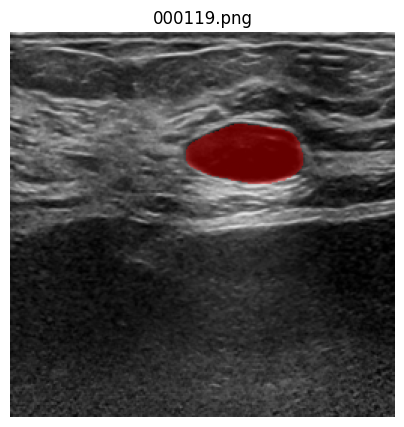

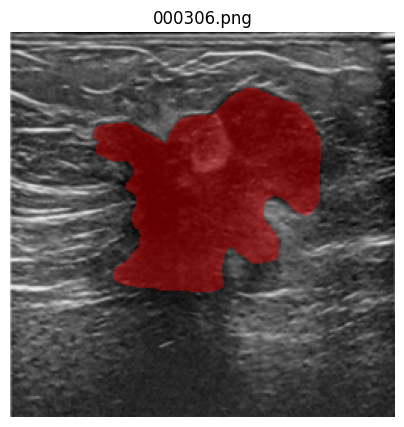

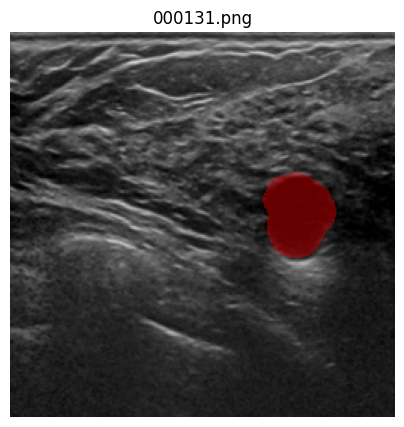

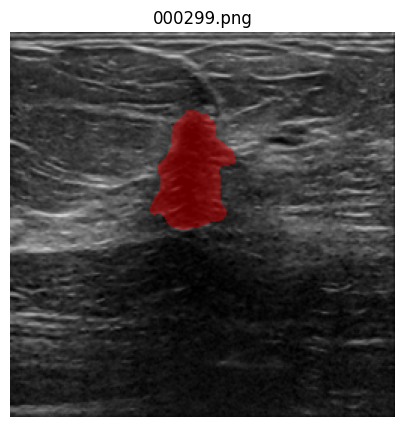

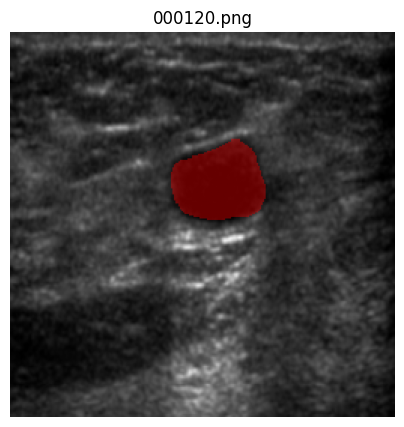

In [4]:
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt

def visualize_overlay(image_path, mask_path, opacity=0.5, mask_color=(1, 0, 0)):
    """
    Overlay binary mask onto image with adjustable opacity and color.
    """
    image = Image.open(image_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")

    image_np = np.array(image) / 255.0
    mask_np = np.array(mask)

    mask_rgb = np.zeros_like(image_np)
    mask_rgb[:, :, 0] = mask_color[0]
    mask_rgb[:, :, 1] = mask_color[1]
    mask_rgb[:, :, 2] = mask_color[2]

    overlay = image_np.copy()
    mask_area = mask_np > 0
    overlay[mask_area] = (1 - opacity) * image_np[mask_area] + opacity * mask_rgb[mask_area]

    plt.figure(figsize=(5, 5))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(os.path.basename(image_path))
    plt.show()

def visualize_random_samples(image_dir, mask_dir, num_samples=5, opacity=0.5, mask_color=(1, 0, 0)):
    """
    Randomly sample images and masks, then visualize them.
    """
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    selected_files = random.sample(image_files, k=min(num_samples, len(image_files)))

    for filename in selected_files:
        image_path = os.path.join(image_dir, filename)
        mask_path = os.path.join(mask_dir, filename)  # Mask has the same name
        visualize_overlay(image_path, mask_path, opacity=opacity, mask_color=mask_color)

# Example usage:
visualize_random_samples(
    image_dir='/mnt/HDD1/tuong/TRUST/dataset/Breast-UDIAT/full/imgs',
    mask_dir='/mnt/HDD1/tuong/TRUST/dataset/Breast-UDIAT/full/masks',
    num_samples=5,
    opacity=0.4,
    mask_color=(1, 0, 0)  # Red overlay
)
